In [43]:
import os
import pandas as pd
import logging

# List of station codes to process
station_codes = [cod_est for cod_est in os.listdir('data/raw') if os.path.isdir(os.path.join('data/raw', cod_est))]

# station_codes = station_codes[1:6]

# Dictionary to store each station's final DataFrame
station_dataframes = {}

for cod_est in station_codes:
    output_dir = f'data/raw/{cod_est}'

    try:
        # Get all CSV files (excluding the final one if re-processing)
        csv_files = [
            f for f in os.listdir(output_dir)
            if f.endswith('.csv') and f.endswith('_TEMPERATURA DO AR - BULBO SECO, HORARIA.csv')
            # if f.endswith('.csv') and not f.endswith('_final.csv')
        ]

        data_frames = []

        for csv_file in csv_files:
            file_path = os.path.join(output_dir, csv_file)

            try:
                df = pd.read_csv(file_path)

                # Convert 'HORA UTC' to datetime
                if 'HORA UTC' in df.columns:
                    df['HORA UTC'] = pd.to_datetime(df['HORA UTC'])
                    df.set_index('HORA UTC', inplace=True)
                else:
                    logging.warning(f"'HORA UTC' column not found in {file_path}")
                    continue

                data_frames.append(df)

            except Exception as e:
                logging.error(f"Error reading file {file_path}: {e}")
                continue

        if not data_frames:
            logging.warning(f"No valid data for station {cod_est}")
            continue

        # Merge all DataFrames by outer join on index
        all_indices = pd.to_datetime(pd.concat([df.index.to_series() for df in data_frames]).unique())
        aligned_data_frames = [df.reindex(all_indices) for df in data_frames]
        final_df = pd.concat(aligned_data_frames, axis=1)

        # Only continue if final_df has at least one row
        if final_df.shape[0] > 0:
            # Reset index to make 'HORA UTC' a column again
            final_df.reset_index(inplace=True)

            # Add 'cod_est' column
            final_df['cod_est'] = cod_est

            # Store result in dictionary
            station_dataframes[cod_est] = final_df

            print(f"Loaded data for station {cod_est}, shape: {final_df.shape}")
        else:
            print(f"Skipping station {cod_est}: final DataFrame has zero rows.")

    except Exception as e:
        logging.error(f"Failed to process station {cod_est}: {e}")

all_stations_df = pd.concat(station_dataframes.values(), ignore_index=True)

# Example usage: view one of the station DataFrames
# display(station_dataframes['A123'])  # Replace with actual station code


Skipping station 83007: final DataFrame has zero rows.
Loaded data for station 83011, shape: (49680, 3)
Loaded data for station 83015, shape: (18630, 3)
Skipping station 83032: final DataFrame has zero rows.
Skipping station 83035: final DataFrame has zero rows.
Loaded data for station 83037, shape: (18630, 3)
Skipping station 83041: final DataFrame has zero rows.
Skipping station 83048: final DataFrame has zero rows.
Loaded data for station 83049, shape: (18630, 3)
Loaded data for station 83054, shape: (49680, 3)
Skipping station 83055: final DataFrame has zero rows.
Loaded data for station 83075, shape: (18630, 3)
Skipping station 83084: final DataFrame has zero rows.
Loaded data for station 83089, shape: (18630, 3)
Loaded data for station 83112, shape: (49680, 3)
Loaded data for station 83114, shape: (18630, 3)
Loaded data for station 83115, shape: (49680, 3)
Loaded data for station 83117, shape: (49680, 3)
Loaded data for station 83118, shape: (49680, 3)
Loaded data for station 834

In [46]:
# Ensure 'HORA UTC' is a datetime column
all_stations_df['HORA UTC'] = pd.to_datetime(all_stations_df['HORA UTC'])

# Filter for rows in year 2008
df_2008 = all_stations_df[all_stations_df['HORA UTC'].dt.year == 2008]

# Optional: check result
print(df_2008.shape)
print(df_2008['HORA UTC'].min(), df_2008['HORA UTC'].max())

(1458144, 3)
2008-01-01 00:00:00 2008-12-31 23:00:00


In [53]:
# Group by station and calculate total records and NaNs
nan_percentage = (
    df_2008.groupby('cod_est')['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .agg(total_records='count', total_nans=lambda x: x.isna().sum() + x.notna().sum() - x.count())
    .reset_index()
)

# Calculate percentage of NaNs
nan_percentage['nan_percent'] = 100 * nan_percentage['total_nans'] / (nan_percentage['total_records'] + nan_percentage['total_nans'])

# Sort by percentage descending
nan_percentage.sort_values(by='nan_percent', ascending=False, inplace=True)

# Optional: display
print(nan_percentage.head(50))


    cod_est  total_records  total_nans  nan_percent
7     83112              0        2928   100.000000
48    83696              0        1098   100.000000
78    83789              0        1098   100.000000
77    83788              0        1098   100.000000
88    83841              0        1098   100.000000
149    A628              0        8784   100.000000
150    A629              0        8784   100.000000
151    A630              0        8784   100.000000
147    A626              0        8784   100.000000
236    A868              0        8784   100.000000
241    A874              0        8784   100.000000
243    B806              0        8784   100.000000
235    A864              0        8784   100.000000
242    B803              0        8784   100.000000
239    A872              0        8784   100.000000
216    A771              0        8784   100.000000
215    A770              0        8784   100.000000
214    A769              0        8784   100.000000
213    A768 

In [54]:
# Step 1: Find stations with total_records > 0
valid_stations = (
    df_2008.groupby('cod_est')['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .apply(lambda x: x.notna().sum())
)
valid_stations = valid_stations[valid_stations > 0].index

# Step 2: Filter df_2008 to keep only valid stations
df_2008_v = df_2008[df_2008['cod_est'].isin(valid_stations)].copy()
df_2008_v

,HORA UTC,"TEMPERATURA DO AR - BULBO SECO, HORARIA",cod_est
0,2008-01-01 00:00:00,20.0,83011
1,2008-01-01 03:00:00,NaN,83011
2,2008-01-01 06:00:00,18.0,83011
3,2008-01-01 09:00:00,20.0,83011
4,2008-01-01 12:00:00,22.0,83011
...,...,...,...
24600379,2008-12-31 19:00:00,27.0,A807
24600380,2008-12-31 20:00:00,26.0,A807
24600381,2008-12-31 21:00:00,25.0,A807
24600382,2008-12-31 22:00:00,22.0,A807


In [56]:
len(df_2008_v['cod_est'].unique())

196

In [57]:
len(df_2008['cod_est'].unique())

244

In [62]:
df_2008_v[df_2008_v['cod_est'] == 'A628']

,HORA UTC,"TEMPERATURA DO AR - BULBO SECO, HORARIA",cod_est


In [64]:
# Group by station and calculate total records and NaNs
nan_percentage = (
    df_2008_v.groupby('cod_est')['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .agg(total_records='count', total_nans=lambda x: x.isna().sum() + x.notna().sum() - x.count())
    .reset_index()
)

# Calculate percentage of NaNs
nan_percentage['nan_percent'] = 100 * nan_percentage['total_nans'] / (nan_percentage['total_records'] + nan_percentage['total_nans'])

# Sort by percentage descending
nan_percentage.sort_values(by='nan_percent', ascending=False, inplace=True)

# Optional: display
print(nan_percentage.tail(50))

    cod_est  total_records  total_nans  nan_percent
139    A709           8778           6     0.068306
83    83840           2926           2     0.068306
117    A546           8779           5     0.056922
110    A523           8779           5     0.056922
52    83721           2927           1     0.034153
81    83829           2927           1     0.034153
66    83768           2928           0     0.000000
65    83767           1098           0     0.000000
8     83115           2928           0     0.000000
11    83464           1098           0     0.000000
27    83582           1098           0     0.000000
26    83579           1098           0     0.000000
24    83576           1464           0     0.000000
22    83570           1098           0     0.000000
20    83533           1098           0     0.000000
29    83616           2928           0     0.000000
31    83623           1098           0     0.000000
32    83630           1098           0     0.000000
1     83015 

In [65]:
nan_percentage

,cod_est,total_records,total_nans,nan_percent
63,83759,445,2483,84.801913
28,83599,634,2294,78.346995
167,A745,2038,6746,76.798725
80,83825,715,2213,75.580601
174,A754,2187,6597,75.102459
...,...,...,...,...
72,83783,1098,0,0.000000
71,83781,1098,0,0.000000
85,83844,1098,0,0.000000
68,83778,2928,0,0.000000


In [66]:
df_all_estacoes = pd.read_csv('Estacoes_BNDMET_2008+.csv')
df_all_estacoes

,codEstacao,nome,situacao,tipo,estado,latitude,longitude,altitudeEmMetros,entidadeResponsavel,dataInicioOperacao,dataFimOperacao,codOscar,codWsi
0,A736,ARIRANHA,Operante,Automatica,SP,-21.133056,-48.840556,525.44,INMET,2007-11-12T21:00:00.000-03:00,NaN,0-2000-0-86841,0-76-0-3503703000000271
1,A725,AVARE,Operante,Automatica,SP,-23.101667,-48.941111,776.36,INMET,2006-09-21T21:00:00.000-03:00,NaN,0-2000-0-86904,0-76-0-3504503000000107
2,A741,BARRA BONITA,Operante,Automatica,SP,-22.471111,-48.557500,533.68,INMET,2008-04-23T21:00:00.000-03:00,NaN,0-2000-0-86867,0-76-0-3505302000000348
3,D7117,BARRA DO ACUNGUI,Operante,Automatica,SP,-24.206400,-47.613300,22.00,ANA,2021-12-31T21:00:00.000-03:00,NaN,NaN,0-76-4-81530000
4,D7070,BARRA DO AZEITE - PCD,Operante,Automatica,SP,-24.800300,-48.173600,0.00,ANA,2021-12-31T21:00:00.000-03:00,NaN,NaN,0-76-4-81699000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,83513,NHUMIRIM (NHECOLANDIA),Desativada,Convencional,MS,-18.988611,-56.622778,102.27,INMET,1984-06-30T21:00:00.000-03:00,2019-11-30T21:00:00.000-03:00,0-2000-0-83513,0-76-0-5003207000W83513
1701,83565,PARANAIBA,Fechada,Convencional,MS,-19.663611,-51.191389,429.62,INMET,1971-07-06T21:00:00.000-03:00,2025-07-01T21:00:00.000-03:00,0-2000-0-83565,0-76-0-5006309000W83565
1702,83703,PONTA PORA,Fechada,Convencional,MS,-22.550000,-55.700000,657.00,DECEA,1960-12-31T21:00:00.000-03:00,2020-03-10T21:00:00.000-03:00,0-2000-0-83703,0-76-1-5006606000W83703
1703,83702,PONTA PORA,Desativada,Convencional,MS,-22.552500,-55.716389,668.00,INMET,1941-11-23T21:00:00.000-03:00,2016-01-31T21:00:00.000-03:00,0-2000-0-83702,0-76-0-5006606000W83702


In [67]:
df_all_estacoes_filtered = df_all_estacoes[
    df_all_estacoes['codEstacao'].isin(nan_percentage['cod_est'])
].copy()
df_all_estacoes_filtered

,codEstacao,nome,situacao,tipo,estado,latitude,longitude,altitudeEmMetros,entidadeResponsavel,dataInicioOperacao,dataFimOperacao,codOscar,codWsi
0,A736,ARIRANHA,Operante,Automatica,SP,-21.133056,-48.840556,525.44,INMET,2007-11-12T21:00:00.000-03:00,NaN,0-2000-0-86841,0-76-0-3503703000000271
1,A725,AVARE,Operante,Automatica,SP,-23.101667,-48.941111,776.36,INMET,2006-09-21T21:00:00.000-03:00,NaN,0-2000-0-86904,0-76-0-3504503000000107
2,A741,BARRA BONITA,Operante,Automatica,SP,-22.471111,-48.557500,533.68,INMET,2008-04-23T21:00:00.000-03:00,NaN,0-2000-0-86867,0-76-0-3505302000000348
5,A746,BARRA DO TURVO,Operante,Automatica,SP,-24.962778,-48.416389,659.89,INMET,2008-07-02T21:00:00.000-03:00,NaN,0-2000-0-86922,0-76-0-3505401000000393
9,A705,BAURU,Operante,Automatica,SP,-22.358056,-49.028889,636.17,INMET,2001-08-29T21:00:00.000-03:00,NaN,0-2000-0-86865,0-76-0-3506003000000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,A754,SIDROLANDIA,Operante,Automatica,MS,-20.981667,-54.971944,471.43,INMET,2008-09-28T21:00:00.000-03:00,NaN,0-2000-0-86809,0-76-0-5007901000000434
1676,A704,TRES LAGOAS,Operante,Automatica,MS,-20.795000,-51.713333,328.94,INMET,2001-09-02T21:00:00.000-03:00,NaN,0-2000-0-86813,0-76-0-5008305000000011
1699,83704,IVINHEMA,Desativada,Convencional,MS,-22.300278,-53.822778,377.40,INMET,1966-07-24T21:00:00.000-03:00,2014-06-30T21:00:00.000-03:00,0-2000-0-83704,0-76-0-5004700000W83704
1701,83565,PARANAIBA,Fechada,Convencional,MS,-19.663611,-51.191389,429.62,INMET,1971-07-06T21:00:00.000-03:00,2025-07-01T21:00:00.000-03:00,0-2000-0-83565,0-76-0-5006309000W83565


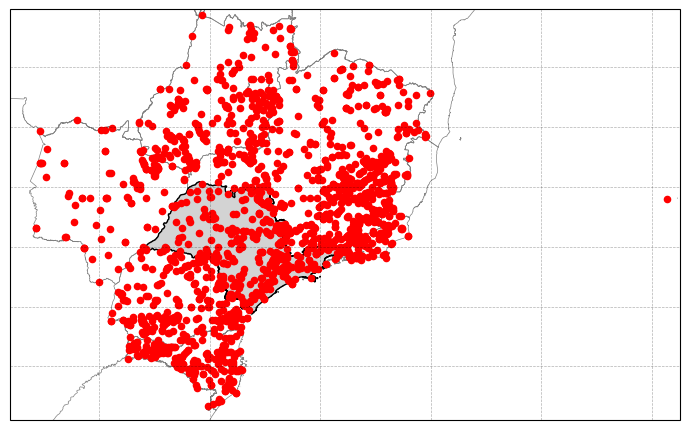

In [68]:
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

def plot_station_locations_all(filtered_df_stations, years, ncols=4):
    """
    Plots station locations for given years in a grid of subplots and saves the entire figure as a PDF file.

    Parameters:
    filtered_df_stations (pd.DataFrame): DataFrame containing the stations data.
    years (list or range): List or range of years to plot.
    ncols (int): Number of columns in the subplot grid (default is 3).

    Returns:
    None
    """
    
    # Calculate global min/max for LATITUDE and LONGITUDE for consistent axis limits
    nx = 0.02
    min_lon = filtered_df_stations['longitude'].min()*(1 + nx)
    max_lon = filtered_df_stations['longitude'].max()*(1 - nx)
    min_lat = filtered_df_stations['latitude'].min()*(1 + nx)
    max_lat = filtered_df_stations['latitude'].max()*(1 - nx)

    # Load the state shape for São Paulo
    gdf = geobr.read_state()
    gdf_sp = gdf[gdf['abbrev_state'] == 'SP']

    # Calculate the number of rows for the subplot grid
    nrows = (len(years) // ncols) + (1 if len(years) % ncols != 0 else 0)

    # Create the main figure for all subplots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7), subplot_kw={'projection': ccrs.PlateCarree()})
    

    # Filter the dataframe for the current year
    
    # Plot the São Paulo state boundary
    gdf.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)
    gdf_sp.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)
            
    # Plot the station locations as a scatter plot
    ax.scatter(
        filtered_df_stations['longitude'], 
        filtered_df_stations['latitude'], 
        color='red', 
        s=20, 
    )
            
    # Set axis limits based on the global min/max
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    
    # Add gridlines
    ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.3, linestyle='--')
        
       # Adjust layout
    plt.tight_layout()

      
# Example of how to call the function
years = range(2008, 2024)
plot_station_locations_all(df_all_estacoes, years)

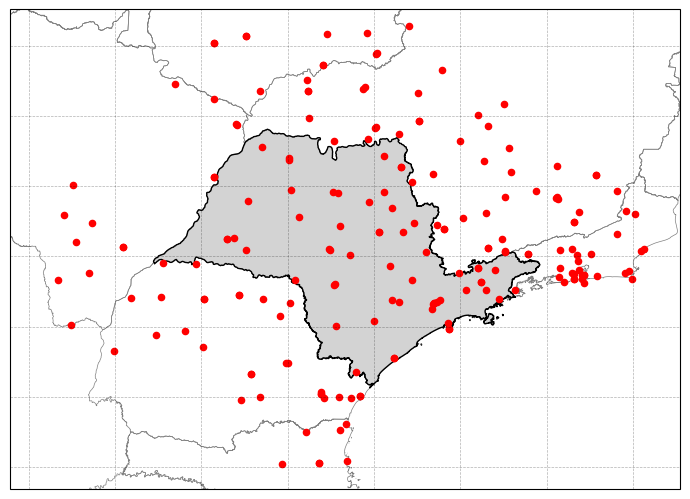

In [69]:
# Example of how to call the function
years = range(2008, 2024)
plot_station_locations_all(df_all_estacoes_filtered, years)

In [72]:
df_all_estacoes = pd.read_csv('Estacoes_BNDMET_filtered_2008+.csv')
df_all_estacoes.head(3)

,codEstacao,nome,situacao,tipo,estado,latitude,longitude,altitudeEmMetros,entidadeResponsavel,dataInicioOperacao,dataFimOperacao,codOscar,codWsi
0,A736,ARIRANHA,Operante,Automatica,SP,-21.133056,-48.840556,525.44,INMET,2007-11-12T21:00:00.000-03:00,NaN,0-2000-0-86841,0-76-0-3503703000000271
1,A725,AVARE,Operante,Automatica,SP,-23.101667,-48.941111,776.36,INMET,2006-09-21T21:00:00.000-03:00,NaN,0-2000-0-86904,0-76-0-3504503000000107
2,A741,BARRA BONITA,Operante,Automatica,SP,-22.471111,-48.557500,533.68,INMET,2008-04-23T21:00:00.000-03:00,NaN,0-2000-0-86867,0-76-0-3505302000000348


In [74]:
# Ensure 'HORA UTC' is a datetime column
all_stations_df['HORA UTC'] = pd.to_datetime(all_stations_df['HORA UTC'])
all_stations_df['ANO'] = pd.to_datetime(all_stations_df['HORA UTC']).dt.year
all_stations_df.head(3)

,HORA UTC,"TEMPERATURA DO AR - BULBO SECO, HORARIA",cod_est,ANO
0,2008-01-01 00:00:00,20.0,83011,2008
1,2008-01-01 03:00:00,NaN,83011,2008
2,2008-01-01 06:00:00,18.0,83011,2008


In [76]:
# Group by 'ANO' and 'cod_est' and calculate total records and NaNs
nan_percentage = (
    all_stations_df.groupby(['ANO', 'cod_est'])['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .agg(
        total_records='count',
        total_nans=lambda x: x.isna().sum() + x.notna().sum() - x.count()
    )
    .reset_index()
)

# Calculate percentage of NaNs
nan_percentage['nan_percent'] = 100 * nan_percentage['total_nans'] / (
    nan_percentage['total_records'] + nan_percentage['total_nans']
)

# Sort by percentage descending
nan_percentage.sort_values(by='nan_percent', ascending=False, inplace=True)
nan_percentage

,ANO,cod_est,total_records,total_nans,nan_percent
4116,2024,A767,0,8784,100.0
7,2008,83112,0,2928,100.0
2442,2018,83037,0,1095,100.0
2441,2018,83015,0,1095,100.0
4129,2024,A824,0,8784,100.0
...,...,...,...,...,...
1741,2015,83630,1095,0,0.0
577,2010,83842,1095,0,0.0
578,2010,83844,1095,0,0.0
1789,2015,83813,1095,0,0.0


In [79]:
# Step 1: Get stations with at least one non-null value per year
valid_stations = (
    all_stations_df.groupby(['ANO', 'cod_est'])['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .apply(lambda x: x.notna().sum())
    .reset_index(name='valid_count')
)

# Keep only rows with at least 1 valid observation
valid_stations = valid_stations[ ['valid_count'] > 0][['ANO', 'cod_est']]

# Step 2: Keep only rows in all_stations_df that match valid (ANO, cod_est) pairs
all_stations_df_v = all_stations_df.merge(valid_stations, on=['ANO', 'cod_est'], how='inner')

# Result
all_stations_df_v


,HORA UTC,"TEMPERATURA DO AR - BULBO SECO, HORARIA",cod_est,ANO
0,2008-01-01 00:00:00,20.0,83011,2008
1,2008-01-01 03:00:00,NaN,83011,2008
2,2008-01-01 06:00:00,18.0,83011,2008
3,2008-01-01 09:00:00,20.0,83011,2008
4,2008-01-01 12:00:00,22.0,83011,2008
...,...,...,...,...
20923901,2024-12-31 19:00:00,26.0,A807,2024
20923902,2024-12-31 20:00:00,22.0,A807,2024
20923903,2024-12-31 21:00:00,21.0,A807,2024
20923904,2024-12-31 22:00:00,20.0,A807,2024


In [83]:
valid_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 4147
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ANO      3366 non-null   int32 
 1   cod_est  3366 non-null   object
dtypes: int32(1), object(1)
memory usage: 65.7+ KB


In [88]:
df_all_estacoes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 1704
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codEstacao           196 non-null    object 
 1   nome                 196 non-null    object 
 2   situacao             196 non-null    object 
 3   tipo                 196 non-null    object 
 4   estado               196 non-null    object 
 5   latitude             196 non-null    float64
 6   longitude            196 non-null    float64
 7   altitudeEmMetros     196 non-null    float64
 8   entidadeResponsavel  196 non-null    object 
 9   dataInicioOperacao   179 non-null    object 
 10  dataFimOperacao      52 non-null     object 
 11  codOscar             196 non-null    object 
 12  codWsi               196 non-null    object 
dtypes: float64(3), object(10)
memory usage: 21.4+ KB


In [93]:
# Group by 'ANO' and 'cod_est' and calculate total records and NaNs
nan_percentage = (
    all_stations_df.groupby(['ANO', 'cod_est'])['TEMPERATURA DO AR - BULBO SECO, HORARIA']
    .agg(
        total_records='count',
        total_nans=lambda x: x.isna().sum() + x.notna().sum() - x.count()
    )
    .reset_index()
)

# Calculate percentage of NaNs
nan_percentage['nan_percent'] = 100 * nan_percentage['total_nans'] / (
    nan_percentage['total_records'] + nan_percentage['total_nans']
)

# Sort by percentage descending
nan_percentage.sort_values(by='nan_percent', ascending=False, inplace=True)
nan_percentage

,ANO,cod_est,total_records,total_nans,nan_percent
4116,2024,A767,0,8784,100.0
7,2008,83112,0,2928,100.0
2442,2018,83037,0,1095,100.0
2441,2018,83015,0,1095,100.0
4129,2024,A824,0,8784,100.0
...,...,...,...,...,...
1741,2015,83630,1095,0,0.0
577,2010,83842,1095,0,0.0
578,2010,83844,1095,0,0.0
1789,2015,83813,1095,0,0.0


In [95]:
# Merge on 'ANO' and 'cod_est'
valid_stations = valid_stations.merge(
    nan_percentage,
    on=['ANO', 'cod_est'],
    how='left'
)
valid_stations

,ANO,cod_est,total_records,total_nans,nan_percent
0,2008,83011,2888,40,1.366120
1,2008,83015,1098,0,0.000000
2,2008,83037,916,182,16.575592
3,2008,83049,1098,0,0.000000
4,2008,83054,2727,201,6.864754
...,...,...,...,...,...
3361,2024,A872,6557,2227,25.352914
3362,2024,A873,8725,59,0.671676
3363,2024,A874,8746,38,0.432605
3364,2024,B803,8781,3,0.034153


In [96]:
# Step 1: Rename 'codEstacao' to 'cod_est' in a copy of df_all_estacoes
stations_geo = df_all_estacoes[['codEstacao', 'latitude', 'longitude']].rename(columns={'codEstacao': 'cod_est'})

# Step 2: Merge valid_stations with the coordinates on 'cod_est'
valid_stations_with_geo = valid_stations.merge(stations_geo, on='cod_est', how='left')

# Optional: check the result
valid_stations_with_geo.rename(columns={'cod_est': 'CODIGO(WMO)', 'latitude' : 'LATITUDE', 'longitude': 'LONGITUDE'}, inplace=True)

valid_stations_with_geo.tail(6)


,ANO,CODIGO(WMO),total_records,total_nans,nan_percent,LATITUDE,LONGITUDE
3360,2024,A871,8783,1,0.011384,-23.773333,-50.180556
3361,2024,A872,6557,2227,25.352914,-24.280278,-50.210278
3362,2024,A873,8725,59,0.671676,-25.508889,-48.808611
3363,2024,A874,8746,38,0.432605,-25.835556,-50.368889
3364,2024,B803,8781,3,0.034153,-24.570833,-52.800278
3365,2024,B806,8700,84,0.956284,-25.322464,-49.157733


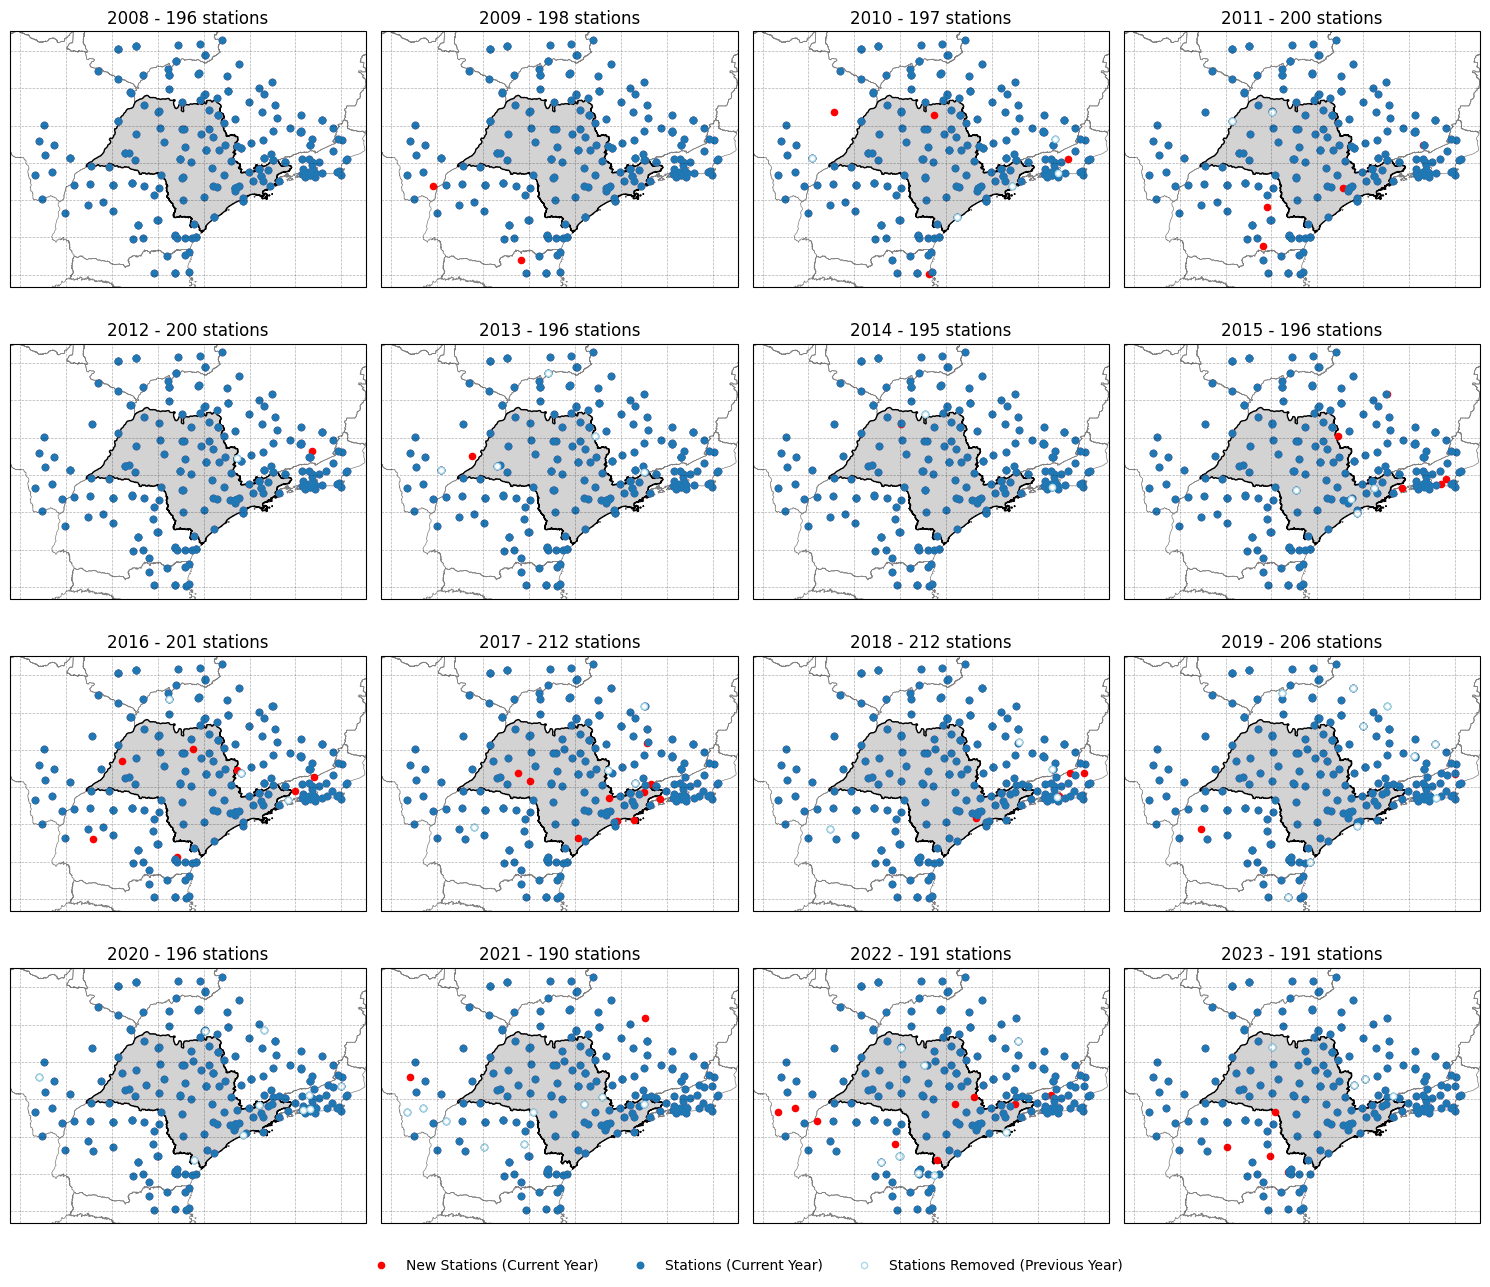

In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_station_locations_all(filtered_df_stations, years, ncols=4):
    """
    Plots station locations for given years in a grid of subplots and saves the entire figure as a PDF file.

    Parameters:
    filtered_df_stations (pd.DataFrame): DataFrame containing the stations data.
    years (list or range): List or range of years to plot.
    ncols (int): Number of columns in the subplot grid (default is 3).

    Returns:
    None
    """
    
    # Calculate global min/max for LATITUDE and LONGITUDE for consistent axis limits
    nx = 0.02
    min_lon = filtered_df_stations['LONGITUDE'].min()*(1 + nx)
    max_lon = filtered_df_stations['LONGITUDE'].max()*(1 - nx)
    min_lat = filtered_df_stations['LATITUDE'].min()*(1 + nx)
    max_lat = filtered_df_stations['LATITUDE'].max()*(1 - nx)

    # Load the state shape for São Paulo
    gdf = geobr.read_state()
    gdf_sp = gdf[gdf['abbrev_state'] == 'SP']

    # Calculate the number of rows for the subplot grid
    nrows = (len(years) // ncols) + (1 if len(years) % ncols != 0 else 0)

    # Create the main figure for all subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3.2), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for idx, year in enumerate(years):
        ax = axes[idx]
        
        # Filter the dataframe for the current year
        
        
        stations_for_year = filtered_df_stations[filtered_df_stations['ANO'] == year]
        stations_for_year_ant = filtered_df_stations[filtered_df_stations['ANO'] == (year-1)]
        
        # Get the list of station IDs (assuming each station has a unique 'station_id' column)
        stations_year_ant_ids = set(stations_for_year_ant['CODIGO(WMO)'])
        stations_year_ids = set(stations_for_year['CODIGO(WMO)'])

        # Find stations in year-1 but not in the current year
        stations_not_in_current_year = stations_year_ant_ids - stations_year_ids

        # Filter the original dataframe to get those stations
        stations_not_in_current_year_df = stations_for_year_ant[stations_for_year_ant['CODIGO(WMO)'].isin(stations_not_in_current_year)]


        if year == 2008:
            stations_for_year_ant = stations_for_year
        
        # Number of stations in the current year
        n_stat = len(stations_for_year)
        
        # Set title
        ax.set_title(f'{year} - {n_stat} stations')
        
        # Plot the São Paulo state boundary
        gdf.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)
        gdf_sp.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)
                
        # Plot the station locations as a scatter plot
        ax.scatter(
            stations_for_year['LONGITUDE'], 
            stations_for_year['LATITUDE'], 
            color='red', 
            s=20, 
            label='New Stations (Current Year)'
        )
        
        ax.scatter(
            stations_for_year_ant['LONGITUDE'], 
            stations_for_year_ant['LATITUDE'], 
            s=22, 
            label='Stations (Current Year)'
        )
        
        ax.scatter(
            stations_not_in_current_year_df['LONGITUDE'], 
            stations_not_in_current_year_df['LATITUDE'], 
            color='white',
            edgecolor='lightblue', 
            s=20, 
            label='Stations Removed (Previous Year)'
        )
                
        # Set axis limits based on the global min/max
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # Add gridlines
        ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.3, linestyle='--')
        
    # Turn off any unused axes
    for i in range(len(years), len(axes)):
        fig.delaxes(axes[i])
        
    
    # handles.extend([new_stations, current_stations, removed_stations])
    labels = ['New Stations (Current Year)', 'Stations (Current Year)', 'Stations Removed (Previous Year)']

    # Add a single legend for the entire figure
    fig.legend(labels=labels, loc='center', ncol=3, bbox_to_anchor=(0.5, -0.0), frameon=False)


    # Adjust layout
    plt.tight_layout()

    # Save the entire subplot as a PDF file
    # plt.savefig('Estacoes_all_years.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
    # plt.close()  # Close the plot to avoid memory issues if generating multiple plots
    
# Example of how to call the function
years = range(2008, 2024)
plot_station_locations_all(valid_stations_with_geo, years)

# "New Stations (Current Year)" clearly indicates these stations are new in the current year.

# "Stations (Current Year)" succinctly describes the stations that are still available in the current year.

# "Stations Removed (Previous Year)" conveys that these stations were present in the previous year but are no longer available.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_station_locations_all(filtered_df_stations, years, ncols=4):
    """
    Plots station locations for given years in a grid of subplots and saves the entire figure as a PDF file.

    Parameters:
    filtered_df_stations (pd.DataFrame): DataFrame containing the stations data.
    years (list or range): List or range of years to plot.
    ncols (int): Number of columns in the subplot grid (default is 3).

    Returns:
    None
    """
    
    # Calculate global min/max for LATITUDE and LONGITUDE for consistent axis limits
    nx = 0.02
    min_lon = filtered_df_stations['LONGITUDE'].min()*(1 + nx)
    max_lon = filtered_df_stations['LONGITUDE'].max()*(1 - nx)
    min_lat = filtered_df_stations['LATITUDE'].min()*(1 + nx)
    max_lat = filtered_df_stations['LATITUDE'].max()*(1 - nx)

    # Load the state shape for São Paulo
    gdf = geobr.read_state()
    gdf_sp = gdf[gdf['abbrev_state'] == 'SP']

    # Calculate the number of rows for the subplot grid
    nrows = (len(years) // ncols) + (1 if len(years) % ncols != 0 else 0)

    # Create the main figure for all subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3.2), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for idx, year in enumerate(years):
        ax = axes[idx]
        
        # Filter the dataframe for the current year
        
        
        stations_for_year = filtered_df_stations[filtered_df_stations['ANO'] == year]
        stations_for_year_ant = filtered_df_stations[filtered_df_stations['ANO'] == (year-1)]
        
        # Get the list of station IDs (assuming each station has a unique 'station_id' column)
        stations_year_ant_ids = set(stations_for_year_ant['CODIGO(WMO)'])
        stations_year_ids = set(stations_for_year['CODIGO(WMO)'])

        # Find stations in year-1 but not in the current year
        stations_not_in_current_year = stations_year_ant_ids - stations_year_ids

        # Filter the original dataframe to get those stations
        stations_not_in_current_year_df = stations_for_year_ant[stations_for_year_ant['CODIGO(WMO)'].isin(stations_not_in_current_year)]


        if year == 2008:
            stations_for_year_ant = stations_for_year
        
        # Number of stations in the current year
        n_stat = len(stations_for_year)
        
        # Set title
        ax.set_title(f'{year} - {n_stat} stations')
        
        # Plot the São Paulo state boundary
        gdf.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)
        gdf_sp.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=1)
                
        # Plot the station locations as a scatter plot
        # ax.scatter(
        #     stations_for_year['LONGITUDE'], 
        #     stations_for_year['LATITUDE'], 
        #     color='red', 
        #     s=20, 
        #     label='New Stations (Current Year)'
        # )
        
        sc = ax.scatter(
            stations_for_year_ant['LONGITUDE'], 
            stations_for_year_ant['LATITUDE'], 
            s=22,
            c = stations_for_year_ant['nan_percent'],
            label='Stations (Current Year)'
        )
        
        # ax.scatter(
        #     stations_not_in_current_year_df['LONGITUDE'], 
        #     stations_not_in_current_year_df['LATITUDE'], 
        #     color='white',
        #     edgecolor='lightblue', 
        #     s=20, 
        #     label='Stations Removed (Previous Year)'
        # )
                
        # Set axis limits based on the global min/max
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # Add gridlines
        ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.3, linestyle='--')
        
    # Turn off any unused axes
    for i in range(len(years), len(axes)):
        fig.delaxes(axes[i])
        
    
    # handles.extend([new_stations, current_stations, removed_stations])
    # labels = ['New Stations (Current Year)', 'Stations (Current Year)', 'Stations Removed (Previous Year)']

    # Add a single legend for the entire figure
    # fig.legend(labels=labels, loc='center', ncol=3, bbox_to_anchor=(0.5, -0.0), frameon=False)


    # Adjust layout
    plt.tight_layout()

    # Save the entire subplot as a PDF file
    # plt.savefig('Estacoes_all_years.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
    # plt.close()  # Close the plot to avoid memory issues if generating multiple plots
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('% Missing Temperature Data')
    
# Example of how to call the function
years = range(2008, 2024)
plot_station_locations_all(valid_stations_with_geo, years)

# "New Stations (Current Year)" clearly indicates these stations are new in the current year.

# "Stations (Current Year)" succinctly describes the stations that are still available in the current year.

# "Stations Removed (Previous Year)" conveys that these stations were present in the previous year but are no longer available.